In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import MerseneTwister
import math
RandomClass = MerseneTwister.Mersenne()
random = RandomClass.randomNumber

Ajax      =  [None, [65,17,18], [54,21,25], [74,14,12], [78,13,9]]
Feyenoord =  [[30,21,49], None, [37,24,39], [51,22,27], [60,21,19]]
PSV       =  [[39,22,39], [54,22,24], None, [62,20,18], [62,22,16]]
FCUtrecht =  [[25,14,61], [37,23,40], [29,24,47], None, [52,23,25]]
WillemII  =  [[17,18,65], [20,26,54], [23,24,53], [37,25,38], None]

teams = ["Ajax", "Feyenoord", "PSV", "FCUtrecht", "WillemII"]
table = pd.DataFrame([Ajax, Feyenoord, PSV, FCUtrecht, WillemII])
table = table.set_index(pd.Index(teams))
table.columns = teams
print(table)

                   Ajax     Feyenoord           PSV     FCUtrecht  \
Ajax               None  [65, 17, 18]  [54, 21, 25]  [74, 14, 12]   
Feyenoord  [30, 21, 49]          None  [37, 24, 39]  [51, 22, 27]   
PSV        [39, 22, 39]  [54, 22, 24]          None  [62, 20, 18]   
FCUtrecht  [25, 14, 61]  [37, 23, 40]  [29, 24, 47]          None   
WillemII   [17, 18, 65]  [20, 26, 54]  [23, 24, 53]  [37, 25, 38]   

               WillemII  
Ajax        [78, 13, 9]  
Feyenoord  [60, 21, 19]  
PSV        [62, 22, 16]  
FCUtrecht  [52, 23, 25]  
WillemII           None  


In [2]:
#Makes a list with 100 items. If the win chanse is 30 than 30 items in this list are 3 (you get 3 points for a win)
#Then randomly picks a item in this list
determinHomePoints = lambda chan: ([3]*chan[0] + [1]*chan[1] + [0]*chan[2])[random([0,99])] if chan != None else None
determinResult = lambda homePoints: (homePoints,{3:0, 1:1, 0:3}[homePoints]) if homePoints != None else None


In [3]:
def runSim(version="base"):
    leaqueTable = table.copy()
    dictOfTeams = {team:0 for team in teams}
    for index, row in leaqueTable.iterrows():
        for colum in list(leaqueTable):
            pointsForHomeTeam = determinHomePoints(leaqueTable[colum][index])
            result = determinResult(pointsForHomeTeam)
            if result != None:
                # colum == awayteam index == hometeam
                dictOfTeams[index] += result[0]
                dictOfTeams[colum] += result[1]

    ranking = pd.Series(dictOfTeams).sort_values(ascending=False)
    return ranking

In [4]:
def runSimulations(numberOfSimulations, version="base"):
    rankingNumbersDict = {i+1:0 for i in range(len(teams))}
    rankingTeams = {team: rankingNumbersDict.copy() for team in teams}
    for simNummer in range(numberOfSimulations):
        seasonRanking = runSim()
        ii = 0
        for i, v in seasonRanking.iteritems():
            rankingTeams[i][ii + 1] += 1
            #Checks if the team is not tied with the one above
            if (ii+1 != len(seasonRanking)-1) and (v != seasonRanking[ii+1]):
                ii += 1
                
    return rankingTeams 

In [5]:
getSimulationResults = lambda numSim, version="base": (pd.DataFrame.from_dict(runSimulations(numSim, version), orient='index') /numSim) * 100
print(getSimulationResults(350))

                   1          2          3          4    5
Ajax       67.714286  20.857143   8.571429   2.857143  0.0
Feyenoord  12.285714  34.000000  32.571429  21.142857  0.0
PSV        28.571429  35.428571  22.571429  13.428571  0.0
FCUtrecht   6.571429  21.142857  30.857143  41.428571  0.0
WillemII    2.571429  13.142857  29.428571  54.857143  0.0


Verdiepend

De bovenstaande similatie in leuk en aardig maar het doel van een simulatie is toch het antwoord geven op een vraagstuk. Ondaks dat dit een leuke similatie is om te doen hebben we niet echt antwoord gegeven op een vraag. Ik heb daarom de vrijheid genomen om zelf een klein onderzoekje optestellen.

Mijn vraag luid als volgd.
Heeft de willekeur van de volgorde waarin de werstreiden gespeeld worden effect op het de freqentie waarmee bepaalde teams op bepaalde posities eindigen.

In de vorige opdracht heeft het resultaat van de vorige wedstijden geen effect gehad op de kans van winnen van de huidigen wedstijd. In die simulatie zou het antwoord dus duidelijk nee zijn.

Het effect van moraal is niet mee genomen (je kan ook stellen dat die al inbegrepen zit in het persentage in dat geval is de willekeur van moraal niet mee genomen). 

Laten wij er van uitgaan dat een team dat 3 wedstijden achter elkaar heeft gewonnen vertrouwen heeft in hun spel en dat dit hun win kans vergroot. Nu maakt de volgorde van de wedstijden potentieel wel uit.

We kunnen iets als het volgende stellen <br>
[Game1, Game2, Game3] = Een lijst met de laatste 3 wedstijden <br>
if [Won, Won, Won]: winkans + 15% <br>
if [Any, Any, Won]: winkans + 5% <br>
if [Any, Any, Loss]: winkans - 5% <br>
if [Loss, Loss, Loss]: winkans - 15%


In [8]:
def determinMotivation(past):
    if past == [3,3,3]:
        return [10,5,-15]
    elif past == [0,0,0]:
        return [-10,-5,15]
    elif past[-1:] == 3:
        return [5,0,-5]
    elif past[-1:] == 0:
        return [-5,0,5]
    else:
        return [0,0,0]

def runSim(version="base"):
    leaqueTable = table.copy()
    dictOfTeams = {team:0 for team in teams}
    pastScoresDict = {team:[None,None,None] for team in teams}
    for index, row in leaqueTable.iterrows():
        for colum in list(leaqueTable):
            pastScore = pastScoresDict[index]
            chanses = leaqueTable[colum][index]
            if chanses == None:
                continue
            elif version == "morale":   
                chanses = [a+b for a, b in zip(determinMotivation(pastScore), leaqueTable[colum][index])]
            
            pointsForHomeTeam = determinHomePoints(chanses)
            result = determinResult(pointsForHomeTeam)
            # colum == awayteam index == hometeam
            dictOfTeams[index] += result[0]
            dictOfTeams[colum] += result[1]
            pastScoresDict[index] = [result[0]] + [pastScore[0]] + [pastScore[1]]
            pastScoreAway = pastScoresDict[colum]
            pastScoresDict[colum] = [result[1]] + [pastScoreAway[0]] + [pastScoreAway[1]]

    ranking = pd.Series(dictOfTeams).sort_values(ascending=False)
    return ranking

In [9]:
print(getSimulationResults(350))
print(getSimulationResults(350, version="morale"))

                   1          2          3          4    5
Ajax       60.000000  27.142857  10.285714   2.571429  0.0
Feyenoord  16.000000  30.000000  31.714286  22.285714  0.0
PSV        32.571429  39.142857  19.142857   9.142857  0.0
FCUtrecht   9.714286  20.285714  28.000000  42.000000  0.0
WillemII    1.428571  13.714286  31.714286  53.142857  0.0
                   1          2          3          4    5
Ajax       61.428571  28.857143   7.428571   2.285714  0.0
Feyenoord  13.428571  34.285714  27.714286  24.571429  0.0
PSV        29.142857  38.857143  18.857143  13.142857  0.0
FCUtrecht   7.142857  18.571429  30.285714  44.000000  0.0
WillemII    2.571429  11.142857  32.000000  54.285714  0.0


op het eerste oog punt zien we niet zo veel verschil

In [10]:
for i in range(50,550,100):
    print((getSimulationResults(350) - getSimulationResults(350, version="morale")).round())


             1    2    3    4    5
Ajax      -1.0  2.0 -1.0  1.0  0.0
Feyenoord  2.0  0.0  3.0 -6.0  0.0
PSV       -1.0  5.0 -6.0  1.0  0.0
FCUtrecht  0.0  3.0 -0.0 -3.0  0.0
WillemII   1.0 -4.0  5.0 -3.0  0.0
             1    2    3    4    5
Ajax       4.0 -1.0 -1.0 -3.0  0.0
Feyenoord  3.0  1.0 -6.0  2.0  0.0
PSV        3.0 -2.0 -1.0 -0.0  0.0
FCUtrecht -3.0  4.0  7.0 -8.0  0.0
WillemII   1.0  2.0  1.0 -5.0  0.0
             1    2    3    4    5
Ajax      -3.0  0.0  3.0 -0.0  0.0
Feyenoord -2.0 -3.0 -1.0  6.0  0.0
PSV       -1.0  1.0  0.0 -1.0  0.0
FCUtrecht  1.0  3.0  2.0 -5.0  0.0
WillemII  -1.0  0.0  2.0 -0.0  0.0
             1    2    3    4    5
Ajax       1.0 -1.0 -1.0  1.0  0.0
Feyenoord  0.0  4.0  2.0 -6.0  0.0
PSV        4.0 -3.0 -1.0  0.0  0.0
FCUtrecht -0.0  2.0  1.0 -3.0  0.0
WillemII  -1.0  2.0  0.0 -2.0  0.0
             1    2    3    4    5
Ajax      -3.0  3.0 -1.0  1.0  0.0
Feyenoord  1.0  5.0  0.0 -5.0  0.0
PSV       -5.0 -1.0  5.0  0.0  0.0
FCUtrecht  0.0 -2.0 

Er is niet echt een trend te zien in het verschil. Het mee nemen van moraal maakt voor deze simulatie dus niet zo veel uit

Poisson verdeeling

De score wordt nu niet meegenomen. Om dit we te doen kunnen we een poisson verdeeling maken. Hiervoor hebben we voor elk team nodig: 
hoeveel ze gemiddeld thuis score (HS), 
hoeveel ze gemiddeld uit score (AS), 
hoeveel ze gemiddeld thuis tegenkrijgen (HC), 
hoeveel ze gemiddeld uit tegenkrijgen (AC)

Deze staan hier onder in een tabel verwerkt

In [126]:
Ajax =	 [3.2, 0.9, 3.1, 0.6]
Feyenoord =	[2.4, 1.1, 2.2, 0.8]
PSV = [2.1, 0.7, 1.8, 1.3]
FCUtrecht = [1.9, 1.2, 3, 2.4]
WillemII = [1.4, 1.7, 1, 1.5]
teams = ["Ajax", "Feyenoord", "PSV", "FCUtrecht", "WillemII"]
averScoreDF = pd.DataFrame([Ajax, Feyenoord, PSV, FCUtrecht, WillemII])
averScoreDF = averScoreDF.set_index(pd.Index(teams))
averScoreDF.columns = ["HS", "HC", "AS", "AC"]

In [131]:
#berekend de kans op een gegeven score gegeven een gemiddelde score
applyPoisson = lambda score, averScore: (averScore**score)*(math.e**-averScore) / math.factorial(score)
getDistribution = lambda averScore: [applyPoisson(i,averScore) for i in range(5)]

def listOfChoises(dis):
    choises = []
    for i in range(len(dis)):
        choises += [i] * round(dis[i]*100)
    return choises 

def getScore(averScore):
    distribution = getDistribution(averScore)
    choises = listOfChoises(distribution)
    score = choises[random([0,len(choises)-1])]
    return score

Omdat we uiteraard willen weten of deze uitwerking klopt moeten we de simulatie een aantal keer runnen en deze dan vergelijken met de kansen.
Hieronder zien we dat de freqentie waarmee een score voorkomt overeenkomt met de kans op deze score. Er gebeurt dus niks raars

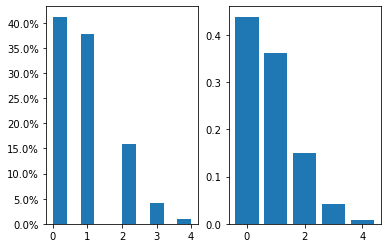

In [132]:
results = [getScore(0.824) for i in range(1000)]
plt.subplot(1, 2, 1)
plt.hist(results, weights=np.ones(len(results)) / len(results))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.subplot(1, 2, 2)
dis = getDistribution(0.824)
forPlot = {dis.index(i):i for i in dis}
plt.bar(range(5), getDistribution(0.824))
plt.show()

In [129]:
def makeSchedule(teams):
    ammountTeams = len(teams)
    schedule = pd.DataFrame(np.zeros((ammountTeams, ammountTeams)))
    schedule.columns = teams
    schedule.index = teams
    return schedule

def playSchedule(schedule, averScoreDF):
    for column in schedule:
        for index, row in schedule.iterrows():
            if index == column:
                schedule[column][index] = None
            else:
                scoreChanseHome = (averScoreDF["HS"][index] + averScoreDF["AC"][column]) /2
                scoreChanseAway = (averScoreDF["AS"][column] + averScoreDF["HC"][index]) /2
                gameResult = "{}:{}".format(getScore(scoreChanseHome), getScore(scoreChanseAway))
                schedule[column][index] = gameResult
    return schedule

In [130]:
print(playSchedule(makeSchedule(teams), averScoreDF))

          Ajax Feyenoord   PSV FCUtrecht WillemII
Ajax       NaN       1:3   1:1       2:2      1:1
Feyenoord  3:2      None   0:0       4:0      2:1
PSV        2:1       0:1  None       4:2      2:1
FCUtrecht  3:3       2:1   2:1      None      2:4
WillemII   2:1       0:1   2:2       0:3     None
